# Term Project
- Student Name: Christohper Poon
- Student UT EID: cmp2263


- Partner Name: Michael Thrash
- Partner UT EID: mat5429

In [415]:
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics

# Research Question: 
- 1st Question: We want to classify a pokemon image and predict the what the pokemon's primary typing will be of the 18 different types
    - We Expect the results to be better than 1/18 or 0.05 but not very high due to background pixel noise
    
    - for simplicity we only looked at primary typing and not dual typing of the pokemon
    
- 2nd Question: We want to classify an image and predict if the pokemon's image is a water type or not a water type
    - We expect the results to be much higher since the classification only includes two different labels 
    
- Classification will be evaulated on the Accuracy Score of corretly getting the pokemon's type

#  DATASET and Images from Kaggle
https://www.kaggle.com/datasets/vishalsubbiah/pokemon-images-and-types

In [416]:
df_pokemon = pd.read_csv('pokemon.csv')
df_pokemon

,Name,Type1,Type2
0,bulbasaur,Grass,Poison
1,ivysaur,Grass,Poison
2,venusaur,Grass,Poison
3,charmander,Fire,NaN
4,charmeleon,Fire,NaN
...,...,...,...
804,stakataka,Rock,Steel
805,blacephalon,Fire,Ghost
806,zeraora,Electric,NaN
807,meltan,Steel,NaN


In [417]:
# Get rid of Nan values and convert type 2 to type 1 for all single types
# index_df = df_pokemon.loc[df_pokemon['Type2'].isna()].index
# df_pokemon['Type2'].iloc[index_df] = df_pokemon['Type1'].iloc[index_df]

# Exploring the dataset

In [418]:
value_count_list = df_pokemon['Type1'].value_counts()
value_count_list

Water       114
Normal      105
Grass        78
Bug          72
Fire         53
Psychic      53
Rock         46
Electric     40
Poison       34
Ground       32
Dark         29
Fighting     29
Ghost        27
Dragon       27
Steel        26
Ice          23
Fairy        18
Flying        3
Name: Type1, dtype: int64

In [423]:
num_water_types = value_count_list['Water']
percent_of_water_types = round((num_water_types / value_count_list.sum()) * 100, 2)
print('Percent of water types:', percent_of_water_types)

Percent of water types: 14.09


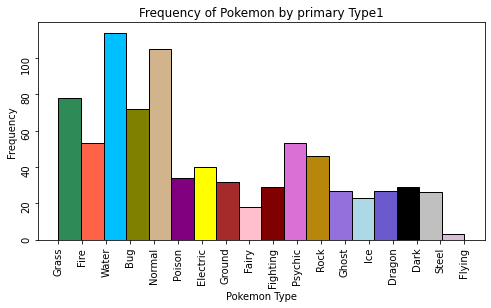

In [424]:
# Frequency of Pokemon types by Type1
colors = ['seagreen', 'tomato', 'deepskyblue', 'olive', 'tan', 'purple', \
          'yellow', 'brown', 'pink', 'maroon', 'orchid', 'darkgoldenrod', \
          'mediumpurple', 'lightblue', 'slateblue', 'black', 'silver', 'thistle']
fig, ax = plt.subplots(figsize=(8,4))
cnts, values, bars = ax.hist(df_pokemon['Type1'], edgecolor='k', bins=18)


for i, (cnt, value, bar) in enumerate(zip(cnts, values, bars)):
    bar.set_facecolor(colors[i % len(colors)])
ax.set_title('Frequency of Pokemon by primary Type1')
ax.set_xlabel('Pokemon Type')
ax.set_ylabel('Frequency')
ax.tick_params(labelrotation=90)

# Create X Feature vector
- image representation into a vector

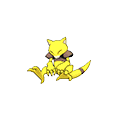

In [425]:
pokemon_name = 'abra'
im = Image.open('PokemonImages/'+pokemon_name+'.png')
im = im.convert(mode='P')
im

In [434]:
abra_pixel = list(im.getdata())
pd.DataFrame(abra_pixel).T

,0,1,2,3,4,5,6,7,8,9,...,14390,14391,14392,14393,14394,14395,14396,14397,14398,14399
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [427]:
def get_image(pokemon_name):
    im = Image.open('PokemonImages/'+pokemon_name+'.png')
    im = im.convert(mode='P')
    pixels = list(im.getdata())
    im.close()
    return pd.DataFrame(pixels).T

In [428]:
df_X = pd.DataFrame()

for p_index, row in df_pokemon.iterrows():
    pokemon_name = df_pokemon.at[p_index,'Name']
    pixel_df = get_image(pokemon_name)
    df_X = pd.concat([df_X, pixel_df], ignore_index=True)
df_X

,0,1,2,3,4,5,6,7,8,9,...,14390,14391,14392,14393,14394,14395,14396,14397,14398,14399
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,46,46,46,46,46,46,46,46,46,46,...,46,46,46,46,46,46,46,46,46,46
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
804,225,225,225,225,225,225,225,225,225,225,...,225,225,225,225,225,225,225,225,225,225
805,225,225,225,225,225,225,225,225,225,225,...,225,225,225,225,225,225,225,225,225,225
806,225,225,225,225,225,225,225,225,225,225,...,225,225,225,225,225,225,225,225,225,225
807,225,225,225,225,225,225,225,225,225,225,...,225,225,225,225,225,225,225,225,225,225


# y1 label: Type 1 all 18 types

In [438]:
# Takes in a pokemon data frame with column ['Type'] 
# Returns a two dictionaries from data frame 
# dictionary 1: {Grass: 0, Fire: 1, Water: 2 ... }
# dictionary 2: {0: Grass, 1: Fire, 2: Water ... }
def create_type_dict(df_data):
    s_typings = pd.Series(df_data['Type1'].unique())
    list_types = s_typings.values
    list_num_types = np.arange(len(list_types))
    dict_typing = dict(zip(list_types,list_num_types))
    num_typing = dict(zip(list_num_types, list_types))
    return dict_typing, num_typing

In [437]:
# take a string pokemon type and convert to a num
# used for an apply function in a dataframe
def change_type_to_num(string_type):
    return dict_typing[string_type]

In [436]:
# take a num pokemon type and convert to the equivalent string
# used for an apply function in a dataframe
def num_to_type(num):
    return num_typing[num]

In [435]:
dict_typing, num_typing = create_type_dict(df_pokemon)
dict_typing

{'Grass': 0,
 'Fire': 1,
 'Water': 2,
 'Bug': 3,
 'Normal': 4,
 'Poison': 5,
 'Electric': 6,
 'Ground': 7,
 'Fairy': 8,
 'Fighting': 9,
 'Psychic': 10,
 'Rock': 11,
 'Ghost': 12,
 'Ice': 13,
 'Dragon': 14,
 'Dark': 15,
 'Steel': 16,
 'Flying': 17}

In [429]:
y1 = pd.Series(df_pokemon['Type1'])
y1 = y1.apply(change_type_to_num)
y1

0       0
1       0
2       0
3       1
4       1
       ..
804    11
805     1
806     6
807    16
808    16
Name: Type1, Length: 809, dtype: int64

# y2 label: Water 1 and everything else 0

In [430]:
def change_water_to_one_coder(string_type):
    if string_type == 'Water':
        return 1
    else:
        return 0

In [431]:
y2 = pd.Series(df_pokemon['Type1'])
y2 = y2.apply(change_water_to_one_coder)
y2.head

<bound method NDFrame.head of 0      0
1      0
2      0
3      0
4      0
      ..
804    0
805    0
806    0
807    0
808    0
Name: Type1, Length: 809, dtype: int64>

# All 18 Labels AdaBoost Classifier

In [390]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier

X_train, X_test, y_train, y_test  = train_test_split(df_X, y1, test_size=0.2, random_state=123)

model = AdaBoostClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


precise_accuracy = np.sum(y_pred == y_test) / len(y_pred)
print(precise_accuracy)

0.19753086419753085


# AdaBoost with 80/20 split on Water 1/0

In [391]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.ensemble import AdaBoostClassifier


X_train, X_test, y_train, y_test  = train_test_split(df_X, y3, test_size=0.2, random_state=123)

model = AdaBoostClassifier(n_estimators=50, learning_rate=1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.84      0.96      0.89       136
           1       0.14      0.04      0.06        26

    accuracy                           0.81       162
   macro avg       0.49      0.50      0.48       162
weighted avg       0.73      0.81      0.76       162



# AdaBoost with StratifiedKFold Cross Validation on Water 1/0

In [392]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import StratifiedKFold

# Create model object
model = AdaBoostClassifier(n_estimators=10, learning_rate=0.5)

# Split data into 10 folds
skf = StratifiedKFold(n_splits=10, random_state=123, shuffle=True)

# Calculate accuracy
n_scores = cross_val_score(model, df_X, y3, scoring='accuracy', cv=skf, n_jobs=-1)

for k_fold, accuracy in enumerate(n_scores):
    print('K fold:', round(k_fold, 2))
    print('Accuracy:', round(accuracy, 2))

print()
print('Mean Accuracy:', round(np.mean(n_scores), 2))
print('Standard Deviation:', round(np.std(n_scores), 2))

K fold: 0
Accuracy: 0.84
K fold: 1
Accuracy: 0.85
K fold: 2
Accuracy: 0.86
K fold: 3
Accuracy: 0.86
K fold: 4
Accuracy: 0.86
K fold: 5
Accuracy: 0.85
K fold: 6
Accuracy: 0.85
K fold: 7
Accuracy: 0.85
K fold: 8
Accuracy: 0.84
K fold: 9
Accuracy: 0.85

Mean Accuracy: 0.85
Standard Deviation: 0.01


# References:
https://archives.bulbagarden.net/wiki/Category:HOME_artwork